In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display, HTML
import ipywidgets as widgets

Load and explore data set

In [ ]:
# Load the dataset
df = pd.read_csv('/content/kalimati-tarkari-prices-from-may-2021-to-september-2023.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/kalimati-tarkari-prices-from-may-2021-to-september-2023.csv'

In [ ]:
df.sample(3)

,Tomato Big(Nepali),1/5/2021,Kg,50,60,55
3989,Sword Bean,2/15/2021,Kg,50,60,55
95874,Onion Dry (Chinese),2023-09-22,KG,Rs 55.00,Rs 60.00,Rs 57.50
41028,Mustard Leaf,3/8/2022,Kg,30,40,35


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96479 entries, 0 to 96478
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Tomato Big(Nepali)  96479 non-null  object
 1   1/5/2021            96479 non-null  object
 2   Kg                  96479 non-null  object
 3   50                  96479 non-null  object
 4   60                  96479 non-null  object
 5   55                  96479 non-null  object
dtypes: object(6)
memory usage: 4.4+ MB


In [ ]:
# The csv lacks any header for their cols
# Add their headers
df.columns = ['Commodity', 'Date', 'Unit', 'Minimum Price', 'Maximum Price', 'Average Price']

In [ ]:
# Recheck
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96479 entries, 0 to 96478
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Commodity      96479 non-null  object
 1   Date           96479 non-null  object
 2   Unit           96479 non-null  object
 3   Minimum Price  96479 non-null  object
 4   Maximum Price  96479 non-null  object
 5   Average Price  96479 non-null  object
dtypes: object(6)
memory usage: 4.4+ MB


Cleaning data

In [ ]:
# Print all unique values in the 'Average Price' column before cleaning
print("Unique Average Price values before:", df['Average Price'].dropna().unique())

# Clean the price columns:
df['Minimum Price'] = df['Minimum Price'].apply(lambda x: float(x.replace('Rs', '').replace('.00', '').strip()) if isinstance(x, str) and x.strip() else None)

df['Maximum Price'] = df['Maximum Price'].apply(lambda x: float(x.replace('Rs', '').replace('.00', '').strip()) if isinstance(x, str) and x.strip() else None)

df['Average Price'] = df['Average Price'].apply(lambda x: x.replace('Rs.,', '').replace('RS.,', '').replace('rS.,', '').replace('rs.,', '').replace('Rs', '').replace('RS', '').replace('rS', '').replace('rs', '').strip() if isinstance(x, str) else x)

# Print all unique values in the 'Average Price' column after cleaning
print("Unique Average Price values after:", df['Average Price'].dropna().unique())

Unique Average Price values before: ['55' '32.5' '42.5' ... 'Rs 334.00' 'Rs 71.20' 'Rs 242.00']
Unique Average Price values after: ['55' '32.5' '42.5' ... '334.00' '71.20' '242.00']


In [ ]:
# Process Year, Month, Day
def process_ymd(date_str):
  # Check if the input is not null, is a string, and not just empty spaces
    if pd.notnull(date_str) and isinstance(date_str, str) and date_str.strip():
        try:
           # Remove extra spaces from the date string
            date_str = date_str.strip()

            # Try to parse the date string with different common date formats
            for fmt in ['%d/%m/%y', '%d-%m-%y', '%Y-%m-%d', '%d/%m/%Y', '%d-%m-%Y']:
                try:
                    dt = datetime.strptime(date_str, fmt)
                    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

                   # Return year, month name, and day
                    return dt.year, month_names[dt.month - 1], dt.day
                except ValueError:

                   # If format doesn't match, try next one
                    continue

                # If date not parsed, try manual splitting by '/' or '-'
            if '/' in date_str or '-' in date_str:
                sep = '/' if '/' in date_str else '-'
                parts = [p.strip() for p in date_str.split(sep)]
                if len(parts) == 3:
                    day, month, year = parts

                    # Handle 2-digit years by assuming 2000+ (e.g., '23' -> 2023)
                    year = int(year) + 2000 if 0 <= int(year) <= 99 else int(year)
                    month = int(month)
                    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

                   # Return the year, month name (default to January if invalid), and day (default to 1 if invalid)
                    return year, month_names[month - 1] if 1 <= month <= 12 else 'January', int(day) if 1 <= int(day) <= 31 else 1
        except (ValueError, IndexError):

          # If any error occurs during parsing, ignore and continue
            pass

    # If input is invalid or parsing fails, return a random date between May 1, 2021 and Sep 30, 2023
    min_date = pd.to_datetime('2021-05-01')
    min_date = pd.to_datetime('2021-05-01')
    max_date = pd.to_datetime('2023-09-30')
    random_dt = min_date + pd.Timedelta(days=np.random.randint(0, (max_date - min_date).days + 1))
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    return random_dt.year, month_names[random_dt.month - 1], random_dt.day

 # Apply the process_ymd function on the 'Date' column of dataframe to get Year, Month, Day columns
df[['Year', 'Month', 'Day']] = df['Date'].apply(lambda x: pd.Series(process_ymd(x)))

# Convert the 'Day' column to nullable integer type
df['Day'] = df['Day'].astype('Int64')

In [ ]:
# Correct grammar
# Clean and fix the 'Commodity' names in the dataframe
df['Commodity'] = df['Commodity'].apply(lambda x:
              # If it's a string that ends with 'ies' (like "batteries"), change 'ies' to 'y' (battery)
              x.strip().title().replace('ies', 'y', 1)
             if isinstance(x, str) and x.lower().endswith('ies') and len(x) > 3

               # Otherwise, if it ends with 's' but not 'ss', remove the trailing 's' (like "apples" -> "Apple")
              else x.strip().title().rstrip('s')
               if isinstance(x, str) and x.lower().endswith('s') and len(x) > 1 and not x.lower().endswith('ss')

               # Otherwise, just clean up spaces and capitalize properly
                else x.strip().title() if isinstance(x, str)

                # If it’s not a string, leave it as is
                else x)

# Standardize the 'Unit' column to common formats
df['Unit'] = df['Unit'].apply(lambda x:

                  # If it contains 'kg' in any form, set as 'KG'
                  'KG' if isinstance(x, str) and any(k in x.upper() for k in ['KG', 'kG', 'Kg'])

                   # If it contains 'per piece' in any form, set as '1 PC'
                   else '1 PC' if isinstance(x, str) and any(p in x for p in ['PER PIECE', 'Per Piece', 'per piece'])

                   # If it contains 'dozen' in any form, set as 'Doz'
                   else 'Doz' if isinstance(x, str) and any(d in x for d in ['DOZEN', 'dozen'])

                   # Otherwise, just clean up spaces and make uppercase
                   else x.strip().upper() if isinstance(x, str)

                  # If it’s not a string, leave it as is
                   else x)

In [ ]:
# Remove rows with all key columns missing except Date
df = df.dropna(subset=['Commodity', 'Unit', 'Minimum Price', 'Maximum Price', 'Average Price'], how='all')

Check updated csv file


In [ ]:
df.sample(3)

,Commodity,Date,Unit,Minimum Price,Maximum Price,Average Price,Year,Month,Day
66652,Avocado,2022-12-07,KG,250.0,300.0,275.00,2022,December,7
63958,Fenugreek Leaf,2022-11-10,KG,200.0,220.0,210.00,2022,November,10
64308,Pomegranate,2022-11-13,KG,400.0,450.0,425.00,2022,November,13


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96479 entries, 0 to 96478
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Commodity      96479 non-null  object 
 1   Date           96479 non-null  object 
 2   Unit           96479 non-null  object 
 3   Minimum Price  96479 non-null  float64
 4   Maximum Price  96479 non-null  float64
 5   Average Price  96479 non-null  object 
 6   Year           96479 non-null  int64  
 7   Month          96479 non-null  object 
 8   Day            96479 non-null  Int64  
dtypes: Int64(1), float64(2), int64(1), object(5)
memory usage: 6.7+ MB


In [ ]:
# Check different unique entries for units as many different types can exist
df['Unit'].unique()

array(['KG', 'DOZ', '1 PC', 'PER DOZEN'], dtype=object)

Clean up more

In [ ]:
# Dtypes of most of the cols are still in object

df['Commodity'] = df['Commodity'].astype('string')
df["Unit"] = df["Unit"].astype("string")
df['Minimum Price'] = np.floor(pd.to_numeric(df['Minimum Price'], errors='coerce')).astype('Int64')
df['Maximum Price'] = np.floor(pd.to_numeric(df['Maximum Price'], errors='coerce')).astype('Int64')
df["Average Price"] = df["Average Price"].astype("float64")
df["Year"] = df["Year"].astype("Int32")
df["Month"] = df["Month"].astype("string")
df["Day"] = df["Day"].astype("Int64")

In [ ]:
# Check again for Dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96479 entries, 0 to 96478
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Commodity      96479 non-null  string 
 1   Date           96479 non-null  object 
 2   Unit           96479 non-null  string 
 3   Minimum Price  96479 non-null  Int64  
 4   Maximum Price  96479 non-null  Int64  
 5   Average Price  96479 non-null  float64
 6   Year           96479 non-null  Int32  
 7   Month          96479 non-null  string 
 8   Day            96479 non-null  Int64  
dtypes: Int32(1), Int64(3), float64(1), object(1), string(3)
memory usage: 6.6+ MB


In [ ]:
# Since months are in string, better to process as int32

df['Month'] = pd.to_datetime(df['Month'], format='%B').dt.month

In [ ]:
# Check out month

# Define the desired order of months
month_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)
df["Month"].unique()

[5, 6, 7, 8, 9, ..., 12, 1, 2, 3, 4]
Length: 12
Categories (12, int64): [1 < 2 < 3 < 4 ... 9 < 10 < 11 < 12]

Visualization

In [ ]:
# Have 2 dfs, one cleaned and one original
# Clean by finding out the IQR and removing it

numeric_cols = ["Maximum Price", "Minimum Price", "Average Price"]

df_cleaned = df.copy()
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

for col in numeric_cols:
    df_cleaned = remove_outliers_iqr(df, col)

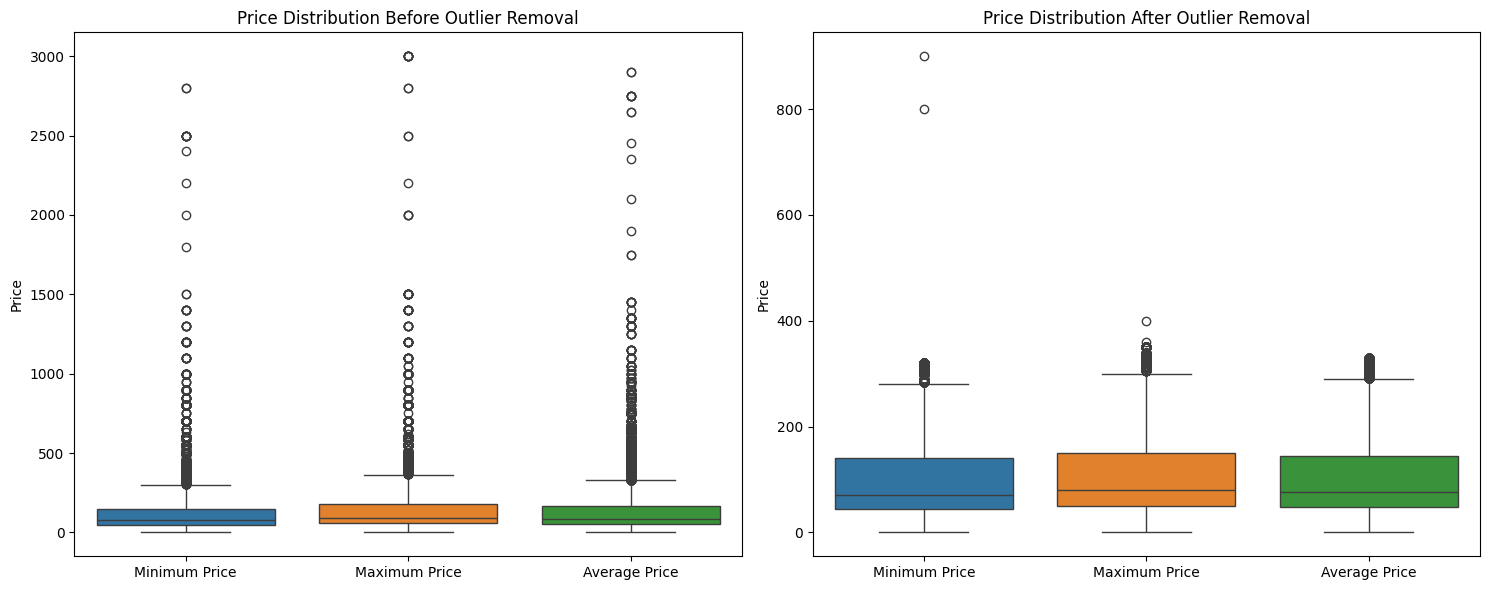

In [ ]:
# prompt: show plots box plots of minimum, maximum and average side by side before and after cleaning

import matplotlib.pyplot as plt
# Before cleaning (using the original df or a copy before outlier removal)
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df[['Minimum Price', 'Maximum Price', 'Average Price']])
plt.title('Price Distribution Before Outlier Removal')
plt.ylabel('Price')

# After cleaning (using df_cleaned)
plt.subplot(1, 2, 2)
sns.boxplot(data=df_cleaned[['Minimum Price', 'Maximum Price', 'Average Price']])
plt.title('Price Distribution After Outlier Removal')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

/tmp/ipython-input-21-3919740602.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date_After'] = pd.to_datetime(df_cleaned[['Year', 'Month']].assign(Day=1))


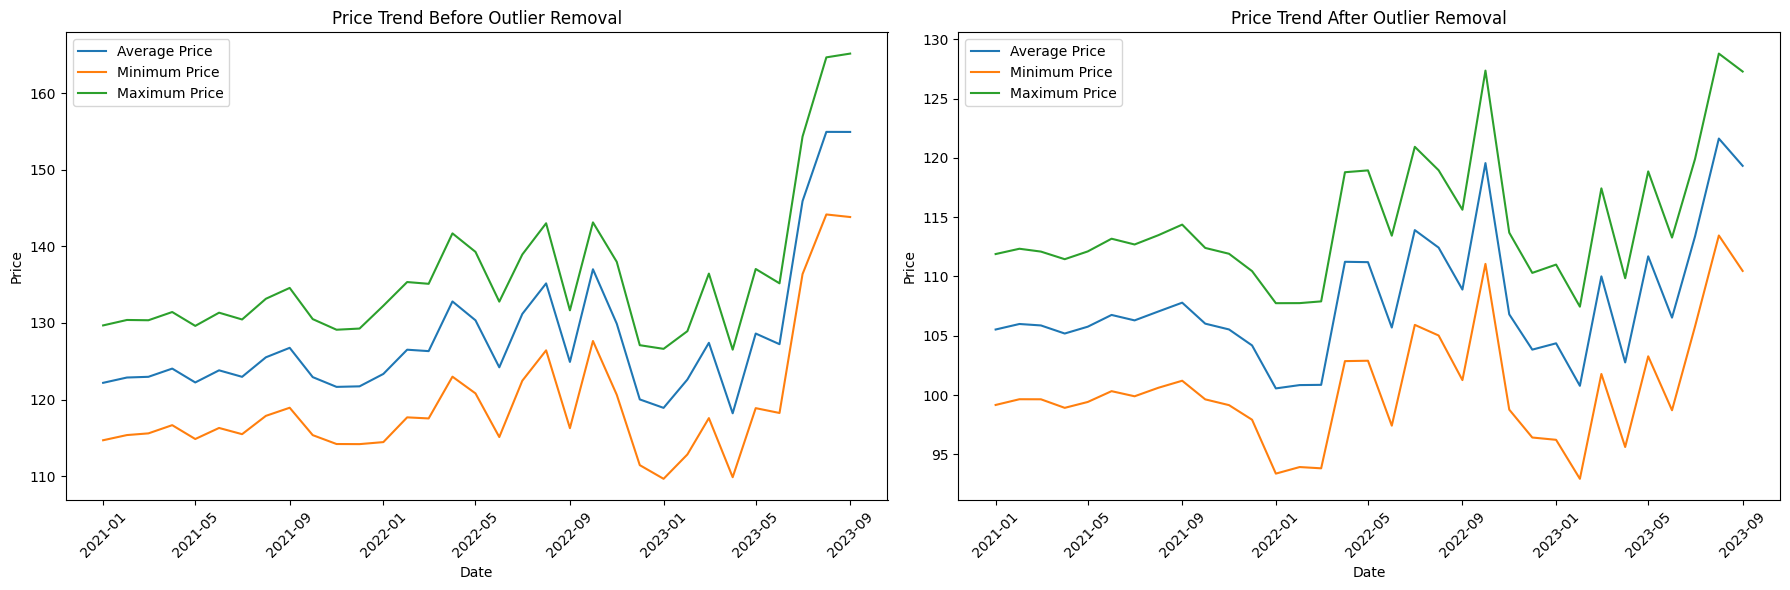

In [ ]:
# Convert Year and Month to datetime objects for better time-based plotting
df['Date_Before'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
df_cleaned['Date_After'] = pd.to_datetime(df_cleaned[['Year', 'Month']].assign(Day=1))

# Group by Date and calculate the mean for trend lines
df_before_trend = df.groupby('Date_Before')[['Minimum Price', 'Maximum Price', 'Average Price']].mean().reset_index()
df_after_trend = df_cleaned.groupby('Date_After')[['Minimum Price', 'Maximum Price', 'Average Price']].mean().reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot trend line before cleaning
sns.lineplot(data=df_before_trend, x='Date_Before', y='Average Price', ax=axes[0], label='Average Price')
sns.lineplot(data=df_before_trend, x='Date_Before', y='Minimum Price', ax=axes[0], label='Minimum Price')
sns.lineplot(data=df_before_trend, x='Date_Before', y='Maximum Price', ax=axes[0], label='Maximum Price')
axes[0].set_title('Price Trend Before Outlier Removal')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45) # Rotate x-axis labels for readability

# Plot trend line after cleaning
sns.lineplot(data=df_after_trend, x='Date_After', y='Average Price', ax=axes[1], label='Average Price')
sns.lineplot(data=df_after_trend, x='Date_After', y='Minimum Price', ax=axes[1], label='Minimum Price')
sns.lineplot(data=df_after_trend, x='Date_After', y='Maximum Price', ax=axes[1], label='Maximum Price')
axes[1].set_title('Price Trend After Outlier Removal')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45) # Rotate x-axis labels for readability


plt.tight_layout()
plt.show()

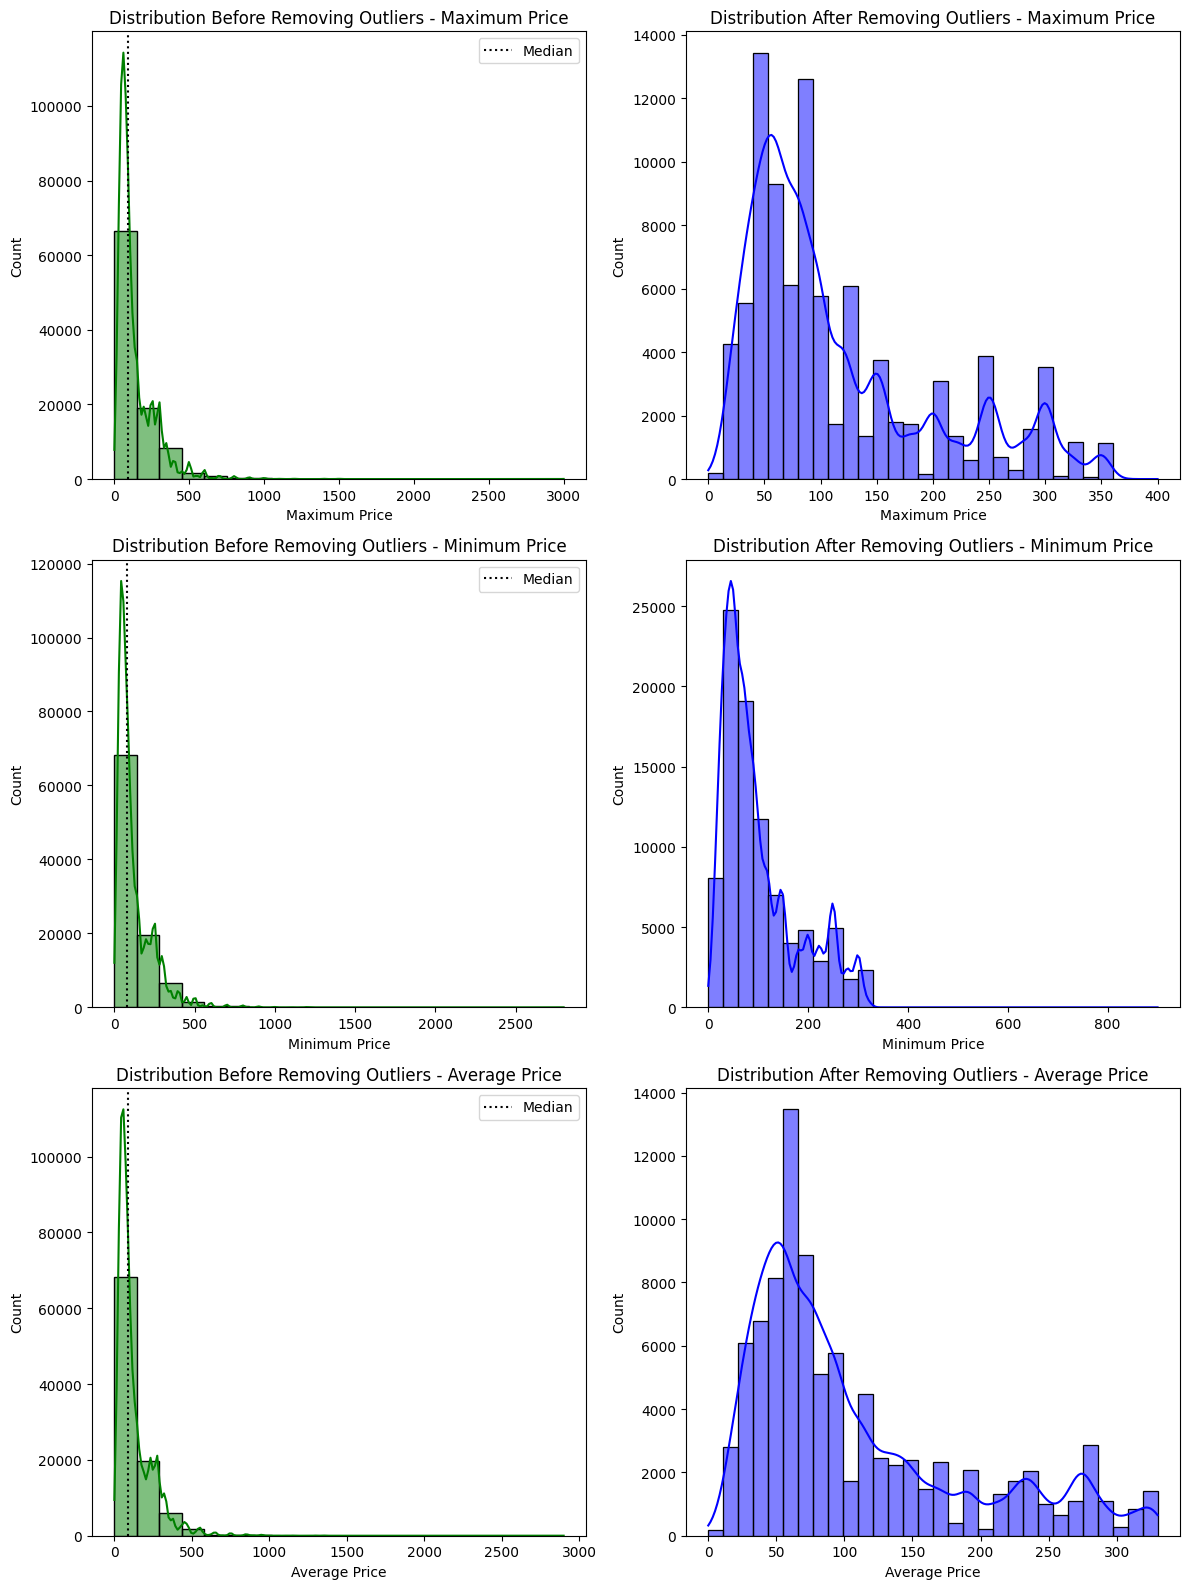

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12,16))

for i, col in enumerate(numeric_cols):
    # Before
    sns.histplot(ax=axes[i, 0], data=df, x=col, bins=20, kde=True, color='green')
    axes[i, 0].set_title(f'Distribution Before Removing Outliers - {numeric_cols[i]}')

    # After
    sns.histplot(ax=axes[i, 1], data=df_cleaned, x=col, bins=30, kde=True, color='blue')
    axes[i, 1].set_title(f'Distribution After Removing Outliers - {numeric_cols[i]}')
    median = df[col].median()
    axes[i, 0].axvline(median, color='black', linestyle=':', label='Median')
    axes[i, 0].legend()


plt.tight_layout()
plt.show()

KPI Visualizations

In [ ]:
#  KPI 1: Trading Volume by Product
volume_df = df['Commodity'].value_counts().reset_index()
volume_df.columns = ['Commodity', 'Trade Volume']
fig1 = px.bar(volume_df.head(10), x='Commodity', y='Trade Volume',
              title=" Top 10 Trading Commodities", height=400, color='Trade Volume')
fig1.show()

In [ ]:
#  KPI 2: Price Trends Over Time
price_trend = df.groupby('Date')['Average Price'].mean().reset_index()
fig2 = px.line(price_trend, x='Date', y='Average Price',
               title=" Average Price Trends Over Time", height=400)
fig2.show()

In [ ]:
# --- KPI 3: Inventory Turnover Rate (proxy = frequency of commodity) ---
turnover_df = df['Commodity'].value_counts().reset_index()
turnover_df.columns = ['Commodity', 'Turnover']
fig3 = px.pie(turnover_df.head(5), names='Commodity', values='Turnover',
              title=" Inventory Turnover Distribution (Top 5)")
fig3.show()

In [ ]:
# KPI 4: Seasonal Trend ====
monthly_avg = df.groupby('Month')['Average Price'].mean().reset_index()
fig4 = px.area(monthly_avg, x='Month', y='Average Price',
               title="Seasonal Price Trend by Month", height=400)
fig4.show()

/tmp/ipython-input-26-2654746167.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
#  KPI 5: Vendor Performance (Price Std Dev)
stability_df = df.groupby('Commodity')['Average Price'].std().reset_index(name='Price Std Dev')
fig5 = px.bar(stability_df.sort_values('Price Std Dev').head(10),
              x='Price Std Dev', y='Commodity', orientation='h',
              title="Most Stable Commodities (Low Price Std Dev)", height=400)
fig5.show()

Train and test splitting

In [ ]:
# Use a simplified and cleaned dataset
df_model = df_cleaned.copy()

# One-hot encode the commodities
df_encoded = pd.get_dummies(df_model, columns=['Commodity', 'Unit', 'Month'], drop_first=True)

# Separate features and target
X = df_encoded.drop(['Average Price', 'Year', 'Date_After', 'Minimum Price', 'Maximum Price'], axis=1)
y = df_encoded['Average Price']

In [ ]:
# Split and test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression

In [ ]:
# Drop string-based date columns
x_train = x_train.drop(columns=['Date', 'Date_After'], errors='ignore')
x_test = x_test.drop(columns=['Date', 'Date_After'], errors='ignore')

# Double-check everything is numeric
x_train = x_train.apply(pd.to_numeric, errors='coerce')
x_test = x_test.apply(pd.to_numeric, errors='coerce')

# Handle any NaNs just in case
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

In [ ]:
# Train linear regression
model = LinearRegression()
model.fit(x_train, y_train)

# Predict
y_pred = model.predict(x_test)

In [ ]:
# Evaluating
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("R² Score:", r2)
print("RMSE:", rmse)

Mean Squared Error: 1319.8362453259053
R² Score: 0.7915540632164235
RMSE: 36.32955057974025


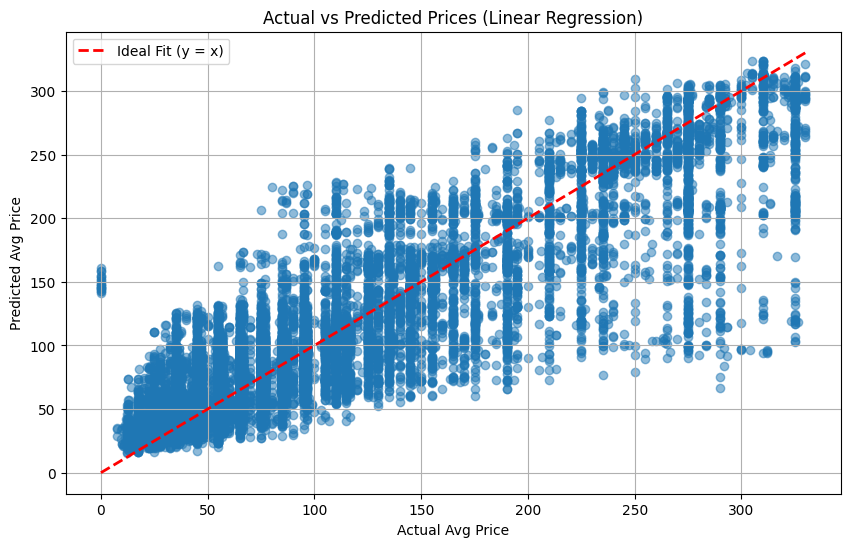

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, linestyle='--',label='Ideal Fit (y = x)')
plt.xlabel("Actual Avg Price")
plt.ylabel("Predicted Avg Price")
plt.title("Actual vs Predicted Prices (Linear Regression)")
plt.grid(True)
plt.legend()
plt.show()

Random Forest

In [ ]:
# Train the random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

# Predict
y_pred = rf.predict(x_test)

In [ ]:
# Evaluating
print("Random Forest Results:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Random Forest Results:
Mean Absolute Error (MAE): 18.64859754033002
Mean Squared Error (MSE): 981.9842197187473
R2 Score: 0.8449121083688532


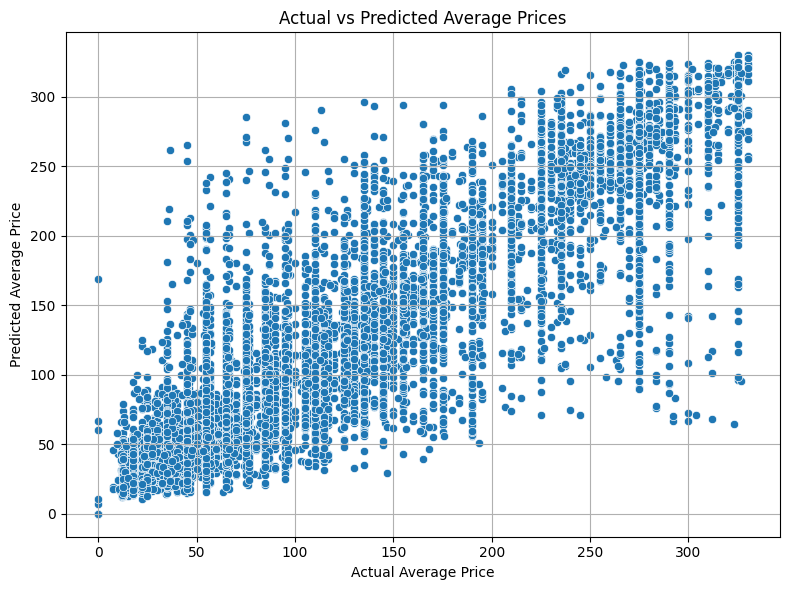

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Average Price")
plt.ylabel("Predicted Average Price")
plt.title("Actual vs Predicted Average Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

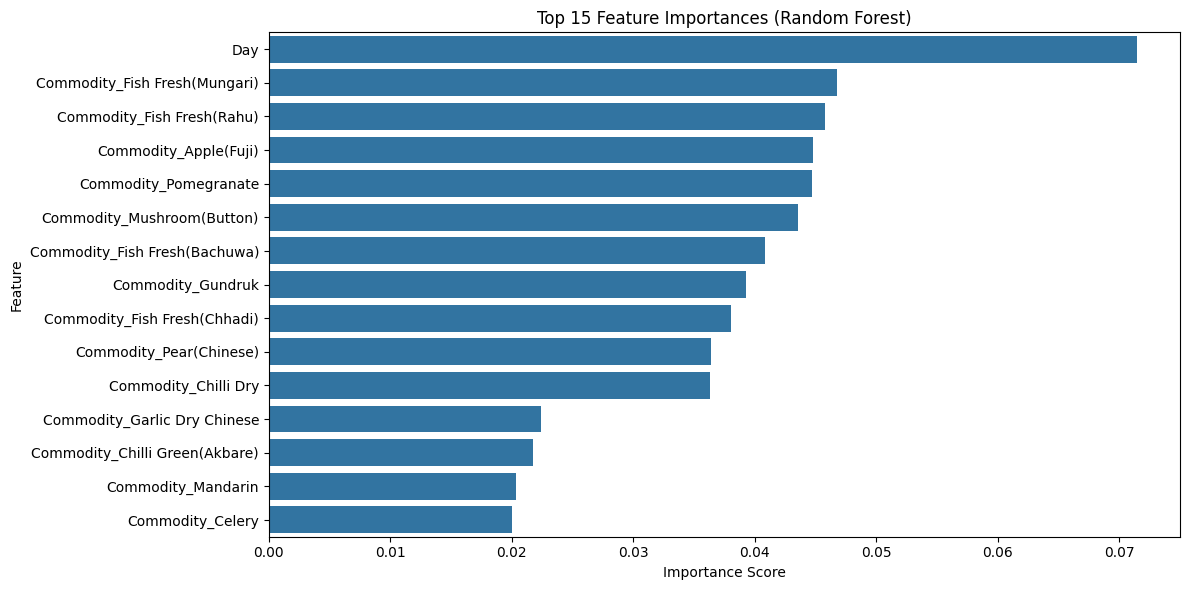

In [ ]:
feature_names = x_train.columns
importances = rf.feature_importances_

feat_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=feat_df[:15], y=feat_df.index[:15])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False] # Whether bootstrap samples are used when building trees
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid_rf,
                              cv=3, # Using 3-fold cross-validation
                              scoring='neg_mean_squared_error',
                              n_jobs=-1, # Use all available cores
                              verbose=2) # Show progress

# Fit GridSearchCV to the training data
print("Starting Random Forest Hyperparameter Tuning...")
grid_search_rf.fit(x_train, y_train)

# Get the best parameters found by GridSearchCV
best_params_rf = grid_search_rf.best_params_
print(f"\nBest parameters for Random Forest: {best_params_rf}")

# Get the best model (trained with the best parameters)
best_rf_model = grid_search_rf.best_estimator_

# Predict using the best model on the test data
y_pred_rf_tuned = best_rf_model.predict(x_test)

# Evaluate the best Random Forest model
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mse_rf_tuned)
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)

print("\nEvaluation metrics for Tuned Random Forest Regression:")
print("Mean Squared Error (MSE):", mse_rf_tuned)
print("R² Score:", r2_rf_tuned)
print("Root Mean Squared Error (RMSE):", rmse_rf_tuned)
print("Mean Absolute Error (MAE):", mae_rf_tuned)

# Plotting Actual vs Predicted Prices for Tuned Random Forest Model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf_tuned, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, linestyle='--', label='Ideal Fit (y = x)')
plt.xlabel("Actual Avg Price")
plt.ylabel("Predicted Avg Price (Tuned RF)")
plt.title("Actual vs Predicted Prices (Tuned Random Forest Regression)")
plt.grid(True)
plt.legend()
plt.show()

OLS

In [ ]:
x_train = x_train.astype(float)
x_test = x_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Add a constant (intercept term)
X_train_ols = sm.add_constant(x_train)
X_test_ols = sm.add_constant(x_test)

# Fit the OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Print the model summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          Average Price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1962.
Date:                Tue, 08 Jul 2025   Prob (F-statistic):               0.00
Time:                        16:26:58   Log-Likelihood:            -3.6546e+05
No. Observations:               73103   AIC:                         7.312e+05
Df Residuals:                   72957   BIC:                         7.326e+05
Df Model:                         145                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Cross Validation

In [ ]:
# Sanitize X for cross-validation
X_clean = X.drop(columns=['Date', 'Date_After'], errors='ignore')  # remove problematic columns
X_clean = X_clean.apply(pd.to_numeric, errors='coerce')  # force all to numeric
X_clean = X_clean.fillna(0)  # handle any conversion NaNs

cv_scores_mse = cross_val_score(model, X_clean, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_rmse = np.sqrt(-cv_scores_mse)

# Report
average_rmse = np.mean(cv_scores_rmse)
std_rmse = np.std(cv_scores_rmse)

print("\nCross-Validation Results (Linear Regression):")
print("RMSE scores for each fold:", cv_scores_rmse)
print("Average RMSE:", average_rmse)
print("Standard Deviation of RMSE:", std_rmse)



Cross-Validation Results (Linear Regression):
RMSE scores for each fold: [33.69926037 41.84129984 38.35726237 42.47330941 42.18840907]
Average RMSE: 39.71190821059336
Standard Deviation of RMSE: 3.354987369582804


In [ ]:
# Sanitize X for Random Forest CV
X_rf_clean = X.drop(columns=['Date', 'Date_After'], errors='ignore')  # drop string-based columns
X_rf_clean = X_rf_clean.apply(pd.to_numeric, errors='coerce') # force everything to numeric
X_rf_clean = X_rf_clean.fillna(0)  # fill missing values

# Cross-validation for Random Forest
cv_scores_mse_rf = cross_val_score(rf, X_rf_clean, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_rmse_rf = np.sqrt(-cv_scores_mse_rf)

# Results
average_rmse_rf = np.mean(cv_scores_rmse_rf)
std_rmse_rf = np.std(cv_scores_rmse_rf)

print("\nCross-Validation Results (Random Forest):")
print("RMSE scores for each fold:", cv_scores_rmse_rf)
print("Average RMSE:", average_rmse_rf)
print("Standard Deviation of RMSE:", std_rmse_rf)



Cross-Validation Results (Random Forest):
RMSE scores for each fold: [35.31759099 45.70695095 43.96156768 49.63311796 47.87228893]
Average RMSE: 44.49830330516627
Standard Deviation of RMSE: 4.975630480814421


In [ ]:

#Dashboard
fig7 = make_subplots(
    rows=3, cols=2,
    specs=[
        [{"type": "xy"}, {"type": "domain"}],
        [{"type": "xy"}, {"type": "xy"}],
        [{"type": "xy"}, {"type": "xy"}]
    ],
    subplot_titles=(
        "Average Market Price Trend Over Time",
        "Top 5 Commodities by Inventory Turnover Rate",
        "Top 10 Commodities by Trading Volume",
        "Seasonal Demand and Supply Trends",
        "Top 10 Commodities with Most Stable Pricing"
    ),
    vertical_spacing=0.15,
    horizontal_spacing=0.2
)
#KPI 1: Average Price Trends (line chart)
fig7.add_trace(fig2.data[0], row=1, col=1)

#KPI 2: Inventory Turnover Rate (pie chart)
for trace in fig3.data:
    fig7.add_trace(trace, row=1, col=2)

#KPI 3: Daily Trading Volume (bar chart)
for trace in fig1.data:
    fig7.add_trace(trace, row=2, col=1)

#KPI 4: Seasonal Demand and Supply (area chart)
fig7.add_trace(fig4.data[0], row=2, col=2)

#KPI 5: Vendor Performance (horizontal bar chart)
for trace in fig5.data:
    fig7.add_trace(trace, row=3, col=1)

# Update layout

fig7.update_layout(
    height=1200,
    width=1000,
    title_text="Market Price Analysis Dashboard",
    showlegend=True,
    coloraxis=dict(
        colorbar=dict(
            len=0.5,
            thickness=15,
            yanchor='middle',
            y=0.5,
            x=1.02
        )
    ),
    title_x=0.5
)


fig7.show()